The solution is partly taken from: 
1. https://mahotas.readthedocs.io/en/latest/edf.html 
2. https://github.com/cmcguinness/focusstack/blob/master/FocusStack.py 


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import mahotas as mh

%matplotlib inline

In [2]:
# for reading pictures
def file_list(root_dir, ext):
    """ 
    Return list of all files with extention
    Inputs:    
        folder: directory
        ext: extention
    Outputs: 
        files: list of filenames
    """
    files = []
    for item in os.listdir(root_dir):
        if item.endswith('.jpg'):
            file_full_path = os.path.join(root_dir, item)
            files.append(file_full_path) 
    
    print('Found {} files in the folder {}'.format(len(files), root_dir))
        
    return files

In [63]:
# read images from folder. Start from some small number of images
# start from grayscale images
fold = r'./nuts/'
files = file_list(fold, '.jpg')
im1 = cv2.imread(files[0], 0)
im2 = cv2.imread(files[1], 0)
im3 = cv2.imread(files[20], 0)
im4= cv2.imread(files[25], 0)
im5 = cv2.imread(files[32], 0)
im6 = cv2.imread(files[39], 0)

print('Image shape is {}'.format(im1.shape))

# stack images together
im_stack = np.dstack((im1, im2, im3, im4, im5, im6))
print('Stacked image shape is {}'.format(im_stack.shape))

Found 40 files in folder ./nuts/
Image shape is (1637, 1783)
Stacked image shape is (1637, 1783, 6)


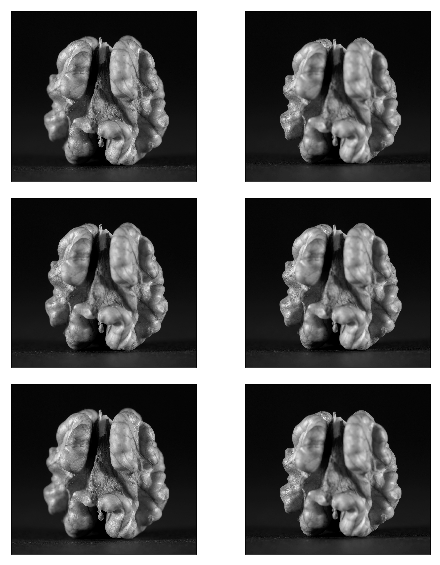

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(im_stack[:,:,i], 'gray')
    axi.set(xticks=[], yticks=[])
plt.subplots_adjust(wspace=0.1, hspace=0.1)


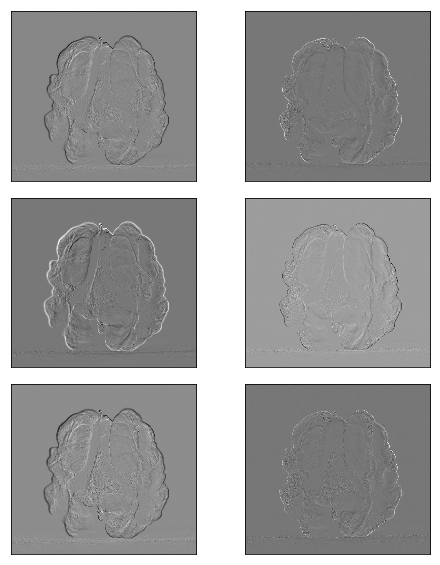

In [13]:
#plt.imshow(mh.sobel(im2, just_filter=True),'gray')

h,w,stack = im_stack.shape
#focus = np.array([mh.sobel(im, just_filter=True) for im in im_stack])
focus = np.array([cv2.Laplacian(im, cv2.CV_64F, ksize=5) for im in im_stack])
best = np.argmax(focus, 2) # the brightest points have the most contrast

fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(focus[:,:,i], 'gray')
    axi.set(xticks=[], yticks=[])
plt.subplots_adjust(wspace=0.1, hspace=0.1)


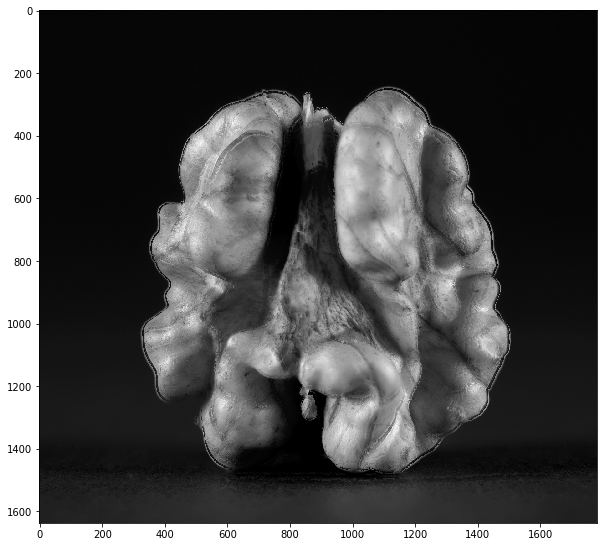

In [14]:
image = im_stack.reshape((-1, stack)) # image is now (n_pixels, stack)

r = image[np.arange(len(image)), best.reshape(-1,)] 
r = r.reshape((h,w)) 
# result 
plt.figure(figsize=(10, 10))
plt.imshow(r.reshape(h,w), 'gray');

In [141]:
fold = r'./nuts/'
files = file_list(fold, '.jpg')
csp = 0

im_stack = cv2.imread(files[0], csp) # first image to get shape
im_stack = im_stack[..., np.newaxis]
for f in files:
    im = cv2.imread(f, csp)
    im = cv2.GaussianBlur(im,(5,5),cv2.BORDER_DEFAULT) # blurr image
    im = im[..., np.newaxis]
    im_stack = np.concatenate((im_stack, im), axis=-1)
im_stack = np.delete(im_stack, 0, -1) # the first was dublicated # ?????????
im_stack.shape

Found 40 files in folder ./nuts/


(1637, 1783, 40)

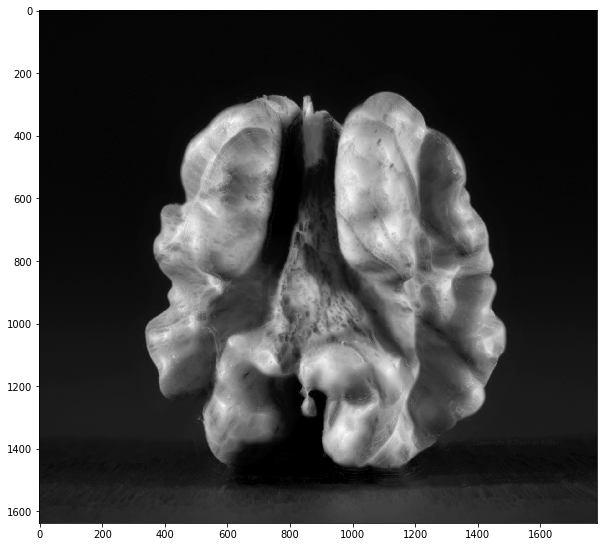

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(focal_stacking(im_stack), 'gray')

## Functions

In [3]:
def image_stack_from_file(fold, color = 0):
    """ grayscale: color = 0 
        rgb: color = 1 """
    files = file_list(fold, '.jpg')

    im_stack = cv2.imread(files[0], color) # first image to get shape
    im_stack = im_stack[..., np.newaxis]
    for f in files:
        im = cv2.imread(f, color)
        if color == 1: 
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        im = cv2.GaussianBlur(im,(5,5),cv2.BORDER_DEFAULT) # blurr image
        im = im[..., np.newaxis]
        im_stack = np.concatenate((im_stack, im), axis=-1)
    
    im_stack = np.delete(im_stack, 0, -1) # the first was dublicated
    print('The result image stack shape is {}'.format(im_stack.shape))   
    
    return im_stack

In [5]:
def match_images(im1, im2):
    n = 10 # best matches
    orb = cv2.ORB_create(10**3)
    kp_1, dsc_1 = orb.detectAndCompute(im1, None)
    kp_2, dsc_2 = orb.detectAndCompute(im2, None)

    # Brut force
    bf=cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches=bf.match(dsc_1, dsc_2)
    matches=sorted(matches, key=lambda x: x.distance)[:n]

    
    # Check plot 
#     draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = (255,0,0),
#                    #matchesMask = matchesMask, # draw only inliers
#                    flags = 2)
    
#     plt.figure(figsize=(13,15))
#     img_match = cv2.drawMatches(im1, kp_1, im2, kp_2, matches[:10], None, **draw_params)
#     plt.imshow(img_match),plt.show()
   
    # Find Homography
    pts_1 = np.float32([kp_1[m.queryIdx].pt for m in matches]).reshape(-1,1,2) # .trainIdx
    pts_2 = np.float32([kp_2[m.trainIdx].pt for m in matches]).reshape(-1,1,2) # .queryIdx

    M, mask = cv2.findHomography(pts_1, pts_2, cv2.RANSAC, ransacReprojThreshold=2.0)
    matchesMask = mask.ravel().tolist()
    
#     # Check plot 
#     draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = (255,0,0),
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)
#     plt.figure(figsize=(13,15))
#     img_match = cv2.drawMatches(im1, kp_1, im2, kp_2, matches[:10], None, **draw_params)
#     plt.imshow(img_match),plt.show()
    
    im_shifted = cv2.warpPerspective(im2, M, (im1.shape[1], im1.shape[0]), 
                                     flags=cv2.INTER_LINEAR)
    #print(M)
    return im_shifted

#im_new = match_images(im1, im2)

In [234]:
# SIFT 
detector = cv2.xfeatures2d.SIFT_create()
kp_1, dsc_1 = detector.detectAndCompute(im1, None)
kp_2, dsc_2 = detector.detectAndCompute(im2, None)

bf = cv2.BFMatcher()
# This returns the top two matches for each feature point (list of list)
pairMatches = bf.knnMatch(dsc_1, dsc_2, k=2)
matches = []
for m,n in pairMatches:
    if m.distance < 0.7*n.distance:
        matches.append(m)
    else:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(dsc_1, dsc_2)


In [12]:
def focal_stacking(im_stack, im_stack_color):
    """Simple focal stacking"""
    
    h, w, stack = im_stack.shape
    c = 3 # color channels
    
    # with sobel filter
    # focus = np.array([mh.sobel(im, just_filter=True) for im in im_stack])
    
    # with laplacian 
    focus = np.array([cv2.Laplacian(im, cv2.CV_64F, ksize=5) for im in im_stack])
    
    # just the brightest points 
    best = np.argmax(focus, 2) # the brightest points have the most contrast
    
#     if im_stack_color == 0: --- ????
#         image = im_stack.reshape((-1, stack)) # image is now (n_pixels, stack)
#         r = image[np.arange(len(image)), best.reshape(-1,)] 
#         r = r.reshape((h,w))
#     else: 

    image = im_stack_color.reshape((-1, c, stack)) # image is now (n_pixels, stack)
    r = image[np.arange(h*w), :,best.reshape(-1,)] 
    r = r.reshape((h,w,c))
    
    return r
   
    
    
#     # -----  Compute the gradient map of the image
#     abs_laps = np.absolute(laps)
#     maxima = abs_laps.max(axis=0)
#     bool_mask = abs_laps == maxima
#     mask = bool_mask.astype(np.uint8)
#     for i in range(0,len(images)):
#         output = cv2.bitwise_not(images[i],output, mask=mask[i])
#     output = 255-output
#     # -----
   

# Main function

Found 40 files in the folder ./nuts/
The result image stack shape is (1637, 1783, 40)
(1637, 1783, 40)
Found 40 files in the folder ./nuts/
The result image stack shape is (1637, 1783, 3, 40)
(1637, 1783, 3, 40)


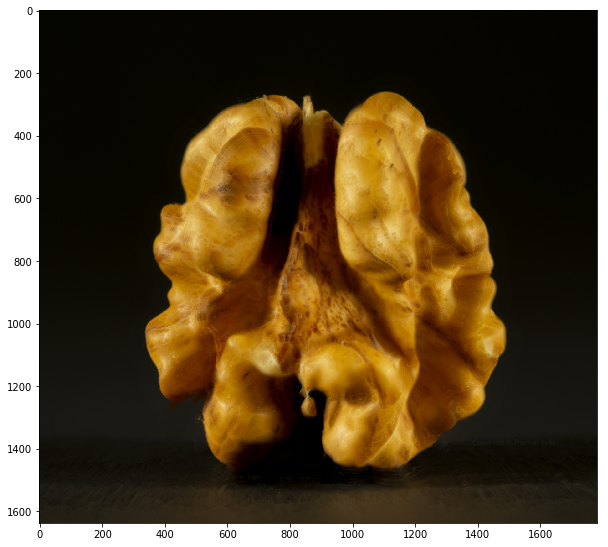

In [16]:
# Read 
fold = r'./nuts/'
im_stack = image_stack_from_file(fold) # gray images 
print(im_stack.shape)
im_stack_color = image_stack_from_file(fold, color=1) # color images
print(im_stack_color.shape)
# print('Stack of images with size {}'.format(im_stack.shape))

# Homography
im_shifted = im_stack[:,:,0] # shift relatively to the first image layer
for i in range(0, im_stack.shape[2]-1):
    homogr = match_images(im_stack[:,:,i], im_stack[:,:,i+1])
    #im_shifted.append(im_stack[:,:,i+1])
    im_shifted = np.dstack((im_shifted, homogr))

# Focus stacking of co
im_focused = focal_stacking(im_stack, im_stack_color)

# Check plot
plt.figure(figsize=(10, 10))
plt.imshow(im_focused, 'gray');